In [138]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [139]:
import json

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import algorithms
import data_generation

## Experiment setup

In [140]:
def run_experiment(feature_dim, norm_w, label_variance=1e-2, num_trials=50, seed=1234):
    # Set up DGP
    dgp = data_generation.LinearDGP(feature_dim=feature_dim,
                                    norm_w=norm_w,
                                    label_variance=label_variance,
                                    seed=seed)
    
    # Compute performative optimum/corresponding loss
    perf_optimum = dgp.compute_performative_optimum()
    po_loss = dgp.population_loss(perf_optimum)
    
    # Sample sizes for two-stage (and max sample for other algorithms)
    sample_sizes = [5 * int(ss) for ss in np.logspace(start=2, stop=4, num=20)]
    
    exp_results = []
    for trial in tqdm(range(num_trials)):
        # Run the two-stage algorithm for variable sample sizes
        for sample_size in sample_sizes:
            theta = algorithms.two_stage_algo(dgp, num_samples=sample_size)
            exp_results.append({
                "algorithm": "Two Stage Algorithm",
                "samples": sample_size,
                "loss": dgp.population_loss(theta),
                "objective-suboptimality": dgp.population_loss(theta) - po_loss,
                "domain-distance": np.linalg.norm(theta - perf_optimum)
            })
            
        # Run Flaxman DFO algorithm
        batch_size = 50
        theta0 = np.ones((dgp.classifier_dim, 1))
        step_sequence = [1e-2 / (t + 1) for t in range(int(max(sample_sizes) / batch_size))]
        thetas = algorithms.flaxman_dfo(dgp, step_sequence=step_sequence,
                                        batch_size=batch_size,
                                        diameter=100.,
                                        theta0=theta0)
        for step, theta in enumerate(thetas):
            if step % 50 != 0:
                continue
            exp_results.append({
                "algorithm": "Flaxman DFO",
                "samples": step * batch_size,
                "loss": dgp.population_loss(theta),
                "objective-suboptimality": dgp.population_loss(theta) - po_loss,
                "domain-distance": np.linalg.norm(theta - perf_optimum)
            })
        
        # Run greedy RRM
        step_sequence = [1. / (np.sqrt(t) + 1) for t in range(int(max(sample_sizes)))]
        thetas = algorithms.greedy_rrm(dgp, step_sequence, theta0=theta0)
        for step, theta in enumerate(thetas):
            if step % 200 != 0:
                continue
            exp_results.append({
                "algorithm": "Greedy RRM",
                "samples": step,
                "loss": dgp.population_loss(theta),
                "objective-suboptimality": dgp.population_loss(theta) - po_loss,
                "domain-distance": np.linalg.norm(theta - perf_optimum)
            })
 
    return exp_results    

In [142]:
results = {}
for norm_w in [1e-3, 10, 100]:
    results[norm_w] = run_experiment(feature_dim=20, norm_w=norm_w, num_trials=10)

## Save data for plotting later

In [143]:
with open("data/linear_model_results.json", "w") as handle:
    json.dump(results, handle)

## Just for me

In [136]:
results = run_experiment(feature_dim=20, norm_w=1e-4, num_trials=1)


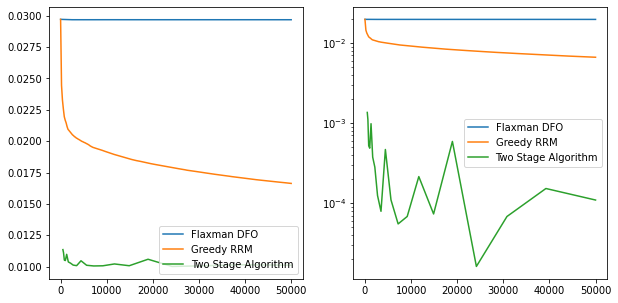

In [137]:
df = pd.DataFrame(results)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for algo in ["Flaxman DFO", "Greedy RRM", "Two Stage Algorithm"]:
    df_algo = df[df.algorithm == algo].sort_values(by="samples")
    axes[0].plot(df_algo.samples, df_algo.loss, label=algo)
    axes[1].semilogy(df_algo.samples, df_algo["objective-suboptimality"], label=algo)
axes[0].legend()
axes[1].legend()